Для первой задачи мы используем данные [Jester Online Joke Recommender System](https://goldberg.berkeley.edu/jester-data/)

**Описание данных**

Файл `train_joke_df.csv` содержит:
- UID - id пользователей
- JID - id шуток, которые 
- Ratin - рейтинг шутки, который проставил пользователь 


Рейтинг имеет значение от -10.00 до 10.00. Могут встречаться значения 99.00, но это обозначает Null (нет рейтинга от пользователя).

Метрика для оценки [RMSE](https://www.codecamp.ru/blog/how-to-interpret-rmse/)

Минимальный RMSE: `4.2238`



In [1]:
#!pip install "scikit-surprise==1.1.3"

In [2]:
#!pip install "xlrd==2.0.1"

### Import

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split
from sklearn.model_selection import train_test_split as tts
from surprise.model_selection import KFold
import time
import datetime
from surprise import SVDpp

import seaborn as sns
from surprise import dump

np.random.seed(42)

### Базовые функции для скоринга и получения рекомендаций

In [2]:
def get_num_user_ratings(uid):
    """ возвращает кол-во рейтингов у пользователя 
    args: 
      uid: id пользователей
    returns: 
      кол-во объектов, которые оценил пользователь
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # пользователя не было во время обучения (новый, отправить на стартовые рекомендации)
        return 0
    
def get_num_item_ratings(iid):
    """ возвращает кол-во пользователей, которые оценили выбранный элемент 
    args:
      iid: строка с элементов рекомендации
    returns:
      кол-во пользователей, которые дали оценки по элементу
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
# На основе Surprise FAQ построим рекомендации Топ-N
def get_top_n(predictions, n=5):
    """Определят Топ-N рекомендаций

    Args:
        predictions(list of Prediction objects): Списко рекомендаций, из алгоритма Surprise
        n(int): Кол-во топ рекомендаций

    Returns:
        Словарь пользователь - список рекомендакиций для пользователей
        [(raw item id, rating estimation), ...]
    """

    # Предикт для каждого пользователя
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Сортировка предикта (по пользователям)
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n    

### Загрузка и обработка данных

In [3]:
df = pd.read_csv(r'data\recsys-in-practice\train_joke_df.csv')

df.head(5)

,UID,JID,Rating
0,18029,6,-1.26
1,3298,64,-4.17
2,3366,58,0.92
3,12735,92,3.69
4,11365,38,-6.60


In [4]:
# сделаем сортировку и перепишем index
df = df.sort_values(by=['UID', 'JID'])
df = df.reset_index(drop=True)

In [5]:
# создадим на основе набора данных
# поднабор, который требуется для библиотеки Surprise

# указываем минимальный и максимальный рейтинги
reader = Reader(rating_scale=(-10, 10))

# передаём набор, указывая последовательность колонок: user (raw) ids, item (raw) ids, ratings
# для Surprise - это обязательно
data = Dataset.load_from_df(df[['UID', 'JID', 'Rating']], reader)

In [6]:
trainset_data = data.build_full_trainset()

# сделаем разделение на обучающую и тестовую выборку
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

### Обучение модели

In [14]:
# определим набор данных для GridSearchCV
t1 = time.time()
print(datetime.datetime.now().strftime("%d.%m.%Y_%H.%M.%S.%f"))
param_grid = {"n_epochs": [10, 20, 50, 100, 200],
              "n_factors": [32, 64, 100, 128, 256, 512, 1024],
              'random_state':[0],
             'cache_ratings':[True, False]}

gs = GridSearchCV(SVDpp, param_grid, measures=["rmse", "mae"], cv=2, n_jobs=-2, joblib_verbose=100)
gs.fit(data)
     

print(datetime.datetime.now().strftime("%d.%m.%Y_%H.%M.%S.%f"))
print('time:', round(time.time() - t1), 'sec')

# результат
print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

27.04.2023_15.02.45.772723
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 tasks      | elapsed:   54.1s
[Parallel(n_jobs=-2)]: Done   2 tasks      | elapsed:   55.5s
[Parallel(n_jobs=-2)]: Done   3 tasks      | elapsed:   59.1s
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-2)]: Done   5 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-2)]: Done   6 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-2)]: Done   7 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-2)]: Done   8 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-2)]: Done   9 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-2)]: Done  10 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-2)]: Done  12 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-2)]: Done  13 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-2)]: Done  14 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-2)]: Done 

In [ ]:
gs.cv_results

In [15]:
# обучим с лучшими параметрами
algo = gs.best_estimator['rmse']
algo.fit(trainset)

# получим предикт и посмотрим метрику
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 4.0765


4.076491323353588

### Тестирование и результаты

In [16]:
# получаем предикт
uid = 1  # id пользователя 
iid = 1  # iв шутки

# получим предик на основе обученных данных
# -7.82 - это фактический рейтинг, но посмотрим, какой ответ будет в предикте
pred = algo.predict(uid, iid, r_ui=-7.82, verbose=True)

user: 1          item: 1          r_ui = -7.82   est = -7.84   {'was_impossible': False}


In [17]:
uid = 24983  # id пользователя 
iid = 62     # iв шутки

pred = algo.predict(uid, iid, r_ui=-0.29, verbose=True)

user: 24983      item: 62         r_ui = -0.29   est = -0.20   {'was_impossible': False}


### Обзор рекомендаций

In [18]:
# построим таблицу для обзора набора рекомендаций
# посмотрим, какие элементы и в каком кол-ве рекомендуем
trainset = algo.trainset

predictions_df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])

predictions_df['№ кол-во пользовательских рейтингов'] = predictions_df.uid.apply(get_num_user_ratings)
predictions_df['№ кол-во рейтингов элементов'] = predictions_df.iid.apply(get_num_item_ratings)
predictions_df['error'] = abs(predictions_df.est - predictions_df.rui)

best_predictions = predictions_df.sort_values(by='error')[:10]
worst_predictions = predictions_df.sort_values(by='error')[-10:]

In [19]:
best_predictions.head(5)

,uid,iid,rui,est,details,№ кол-во пользовательских рейтингов,№ кол-во рейтингов элементов,error
172472,14393,9,-1.75,-1.750009,{'was_impossible': False},59,10082,0.000009
256533,23860,34,-0.53,-0.529986,{'was_impossible': False},62,13726,0.000014
4439,12923,64,2.62,2.620027,{'was_impossible': False},46,11146,0.000027
210880,2665,28,-0.19,-0.190042,{'was_impossible': False},30,15302,0.000042
276575,9373,45,0.24,0.239906,{'was_impossible': False},41,13758,0.000094


In [20]:
# Предикт для всех, кого нет в выборке для обучения
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions)

# Сделаем вывод рекомендаций
a=0
for uid, user_ratings in top_n.items():
    a+=1
    print(uid, [iid for (iid, _) in user_ratings])
    
    if a==10:
        break

19208 [54, 89, 65, 78, 81]
8671 [8, 83, 32, 21, 19]
6037 [76, 81, 36, 87, 89]
3233 [50, 36, 27, 31, 42]
3449 [100, 73, 80, 83, 6]
10032 [35, 32, 53, 29, 49]
5774 [32, 29, 76, 47, 40]
23392 [53, 36, 29, 62, 72]
3039 [62, 53, 36, 89, 27]
17395 [27, 89, 50, 88, 11]


### Для отправки на тестирование

In [8]:
t1 = time.time()
# обучим с лучшими параметрами
algo = SVDpp(n_epochs=200, n_factors=256, random_state=0, cache_ratings=True)
algo.fit(trainset_data)

# получим предикт и посмотрим метрику
predictions = algo.test(trainset_data.build_testset())
accuracy.rmse(predictions)

print('time:', round(time.time() - t1), 'sec')

RMSE: 0.4238
time: 25927 sec


In [9]:
file_name = 'baseline_svdpp_tuning_all_data'
dump.dump(file_name, algo=algo)
#_, loaded_algo = dump.load(file_name)

In [10]:
test = pd.read_csv(r'data\recsys-in-practice\test_joke_df_nofactrating.csv', index_col=0)
test.head(5)

,UID,JID
InteractionID,,
0,11228,39
1,21724,85
2,16782,56
3,12105,42
4,14427,2


In [11]:
test['Rating'] = test[['UID', 'JID']].apply(lambda x: algo.predict(x[0], x[1], verbose=False).est,
                                                      axis = 1)
                                                      


In [12]:
# вид набора данных, который должен быть отправлен для тестирования
test['Rating'].to_frame().head(5)

,Rating
InteractionID,
0,1.648007
1,-6.998847
2,0.228860
3,6.469982
4,6.507208


In [13]:
# формирование файла для отправки в Kaggle
test['Rating'].to_frame().to_csv('baseline_svdpp_tuning_all_data.csv')

C:\ProgramData\Anaconda3\envs\torchvision\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Rating', ylabel='Density'>

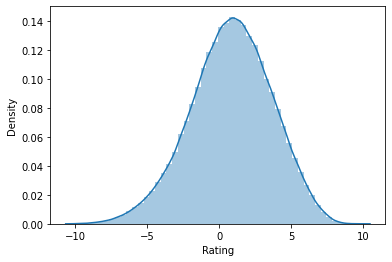

In [14]:
sns.distplot(test['Rating'])

In [ ]:
algo.predict(11228, 39, verbose=False)

In [ ]:
algo.estimate(u=11228, i=39)

In [ ]:
algo.qi.shape, algo.bi.shape

In [ ]:
algo.bu.shape, algo.pu.shape, algo.yj.shape